### Generalized Additive Models

In [1]:
import pandas as pd #для чтения данных и манипуляции с ними
import matplotlib.pyplot as plt #для более тонкого рисования
import seaborn as sns #для более быстрого рисования
from pygam import GAM, s, f, LogisticGAM #основное, с чем мы работаем
import numpy as np #для перекодировки

### Заход с гаусса

Посмотрим на датасет, полученный из данных [Programme for International Student Assessment](http://www.oecd.org/pisa/) и обработанный Michael Clark для своего [собственного туториала](https://m-clark.github.io/generalized-additive-models/preface.html):

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/m-clark/generalized-additive-models/master/data/pisasci2006.csv')

In [3]:
data.head()

,Country,Overall,Issues,Explain,Evidence,Interest,Support,Income,Health,Edu,HDI
0,Albania,NaN,NaN,NaN,NaN,NaN,NaN,0.599,0.886,0.716,0.724
1,Argentina,391.0,395.0,386.0,385.0,567.0,506.0,0.678,0.868,0.786,0.773
2,Australia,527.0,535.0,520.0,531.0,465.0,487.0,0.826,0.965,0.978,0.920
3,Austria,511.0,505.0,516.0,505.0,507.0,515.0,0.835,0.944,0.824,0.866
4,Azerbaijan,382.0,353.0,412.0,344.0,612.0,542.0,0.566,0.780,NaN,NaN


In [4]:
data = data.dropna() #избавимся от пропущенных строк

In [5]:
data.head()

,Country,Overall,Issues,Explain,Evidence,Interest,Support,Income,Health,Edu,HDI
1,Argentina,391.0,395.0,386.0,385.0,567.0,506.0,0.678,0.868,0.786,0.773
2,Australia,527.0,535.0,520.0,531.0,465.0,487.0,0.826,0.965,0.978,0.920
3,Austria,511.0,505.0,516.0,505.0,507.0,515.0,0.835,0.944,0.824,0.866
5,Belgium,510.0,515.0,503.0,516.0,503.0,492.0,0.831,0.935,0.868,0.877
6,Brazil,390.0,398.0,390.0,378.0,592.0,519.0,0.637,0.818,0.646,0.695


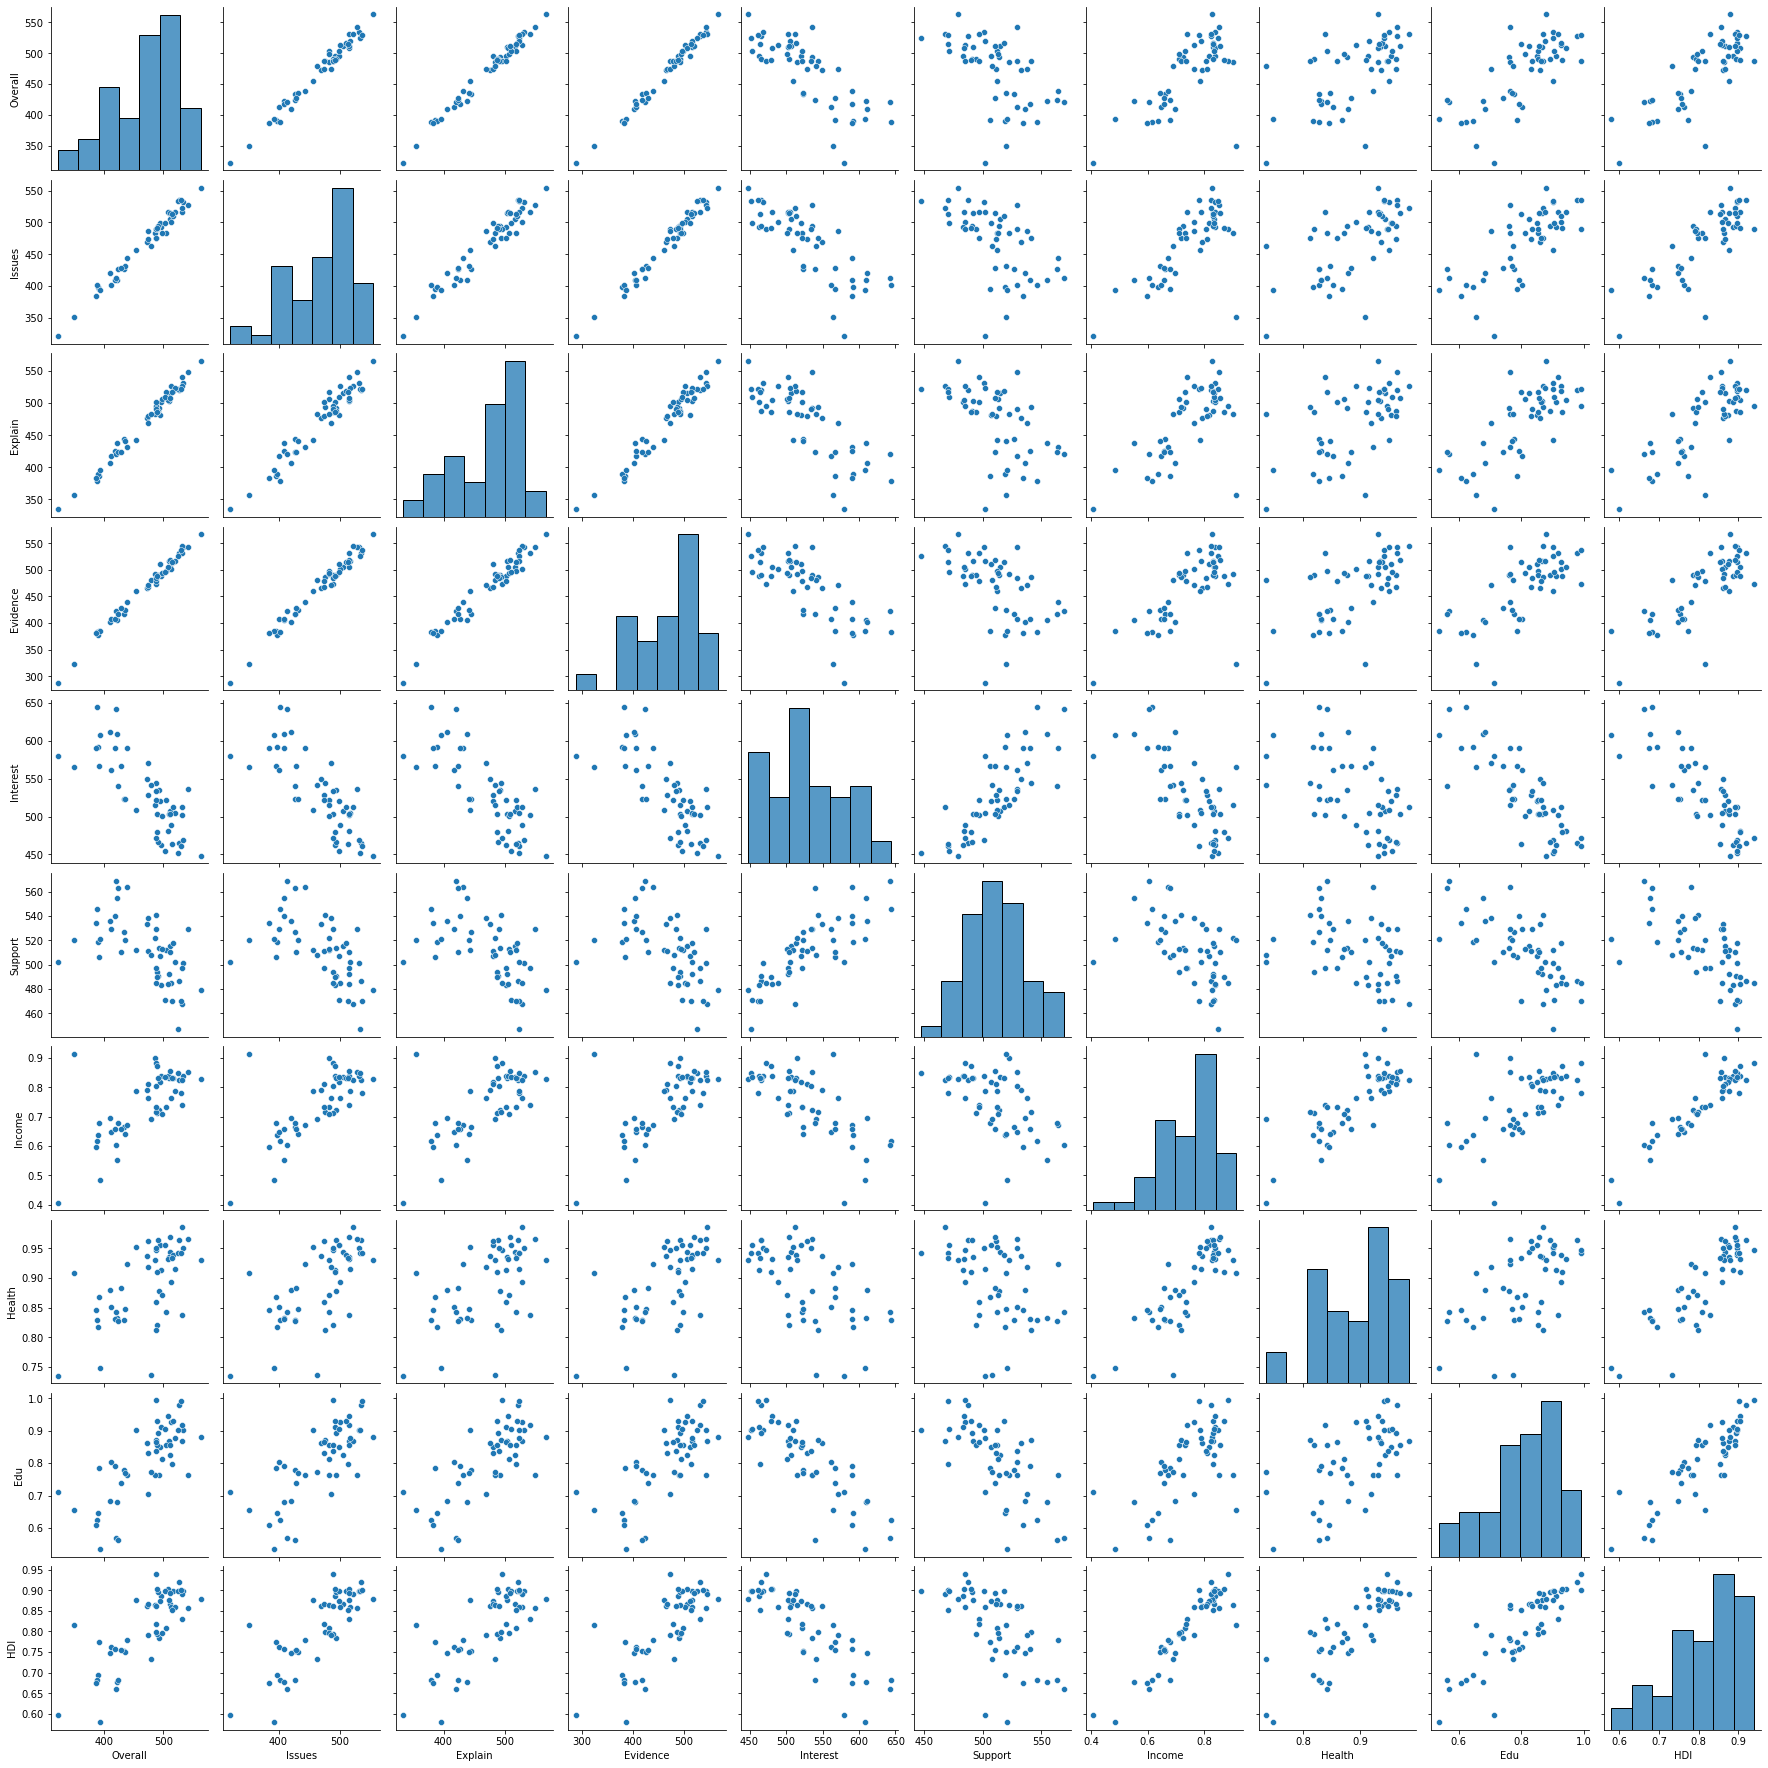

In [5]:
sns.pairplot(data.drop('Country', axis = 1)) #нарисуем попарные скаттерплоты для всех переменных

На первый взгляд датасет выглядит подозрительно линейным. Однако в нём можно найти и вот такие взаимосвязи:

<AxesSubplot:xlabel='Income', ylabel='Edu'>

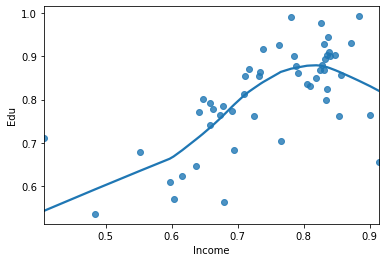

In [7]:
sns.regplot(x = 'Income', y = 'Edu', lowess = True, data = data)

Чтобы построить модель, нужно разделить данные на зависимую переменную и предикторы. Пусть зависимой переменной будет уровень образования, независимыми - индексы интереса к науке, поддержки науки, дохода и уровня здоровья:

In [8]:
X = data.loc[:, ['Interest', 'Support', 'Income', 'Health']] #предикторы
y = data.loc[:, 'Edu'] #зависимая переменная

Построим с дефолтными характеристиками:

In [9]:
first_time = GAM().fit(X, y) 

In [10]:
first_time.summary() #общее описание модели

GAM                                                                                                       
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     14.5776
Link Function:                     IdentityLink Log Likelihood:                                 -4831.1718
Number of Samples:                           52 AIC:                                             9693.4987
                                                AICc:                                            9708.0792
                                                GCV:                                                0.0072
                                                Scale:                                              0.0037
                                                Pseudo R-Squared:                                   0.7866
Feature Function                  Lam

<ipython-input-10-4d0ef17e9b77>:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  first_time.summary() #общее описание модели


Не пугайтесь кучи предупреждений - `pyGAM` не очень хорошо считает значимость результатов, и это никак не могут пофиксить. Можно воздержаться от интерпретации статистической значимости и смотреть на визуализацию эффектов.

In [11]:
#зададим теперь эксплицитно наши параметры

second_model = GAM(s(0) + s(1) + s(2) + s(3)).fit(X, y) 

In [12]:
second_model.summary() #то же самое

GAM                                                                                                       
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     14.5776
Link Function:                     IdentityLink Log Likelihood:                                 -4831.1718
Number of Samples:                           52 AIC:                                             9693.4987
                                                AICc:                                            9708.0792
                                                GCV:                                                0.0072
                                                Scale:                                              0.0037
                                                Pseudo R-Squared:                                   0.7866
Feature Function                  Lam

<ipython-input-12-f6584e3a5aa0>:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  second_model.summary() #то же самое


Чтобы интерпретировать результаты, нам нужно нарисовать графики для каждого отдельного предиктора. Нам понадобятся два основных метода:

* `.generate_X_grid()` - задаёт разрешение линии (насколько тонко он её будет прорисовывать)
* `.partial_dependence()` - считает значения самой линии + доверительный интервал

In [14]:
second_model.generate_X_grid(term=3, n=100)

array([[0.        , 0.        , 0.        , 0.735     ],
       [0.        , 0.        , 0.        , 0.73753535],
       [0.        , 0.        , 0.        , 0.74007071],
       [0.        , 0.        , 0.        , 0.74260606],
       [0.        , 0.        , 0.        , 0.74514141],
       [0.        , 0.        , 0.        , 0.74767677],
       [0.        , 0.        , 0.        , 0.75021212],
       [0.        , 0.        , 0.        , 0.75274747],
       [0.        , 0.        , 0.        , 0.75528283],
       [0.        , 0.        , 0.        , 0.75781818],
       [0.        , 0.        , 0.        , 0.76035354],
       [0.        , 0.        , 0.        , 0.76288889],
       [0.        , 0.        , 0.        , 0.76542424],
       [0.        , 0.        , 0.        , 0.7679596 ],
       [0.        , 0.        , 0.        , 0.77049495],
       [0.        , 0.        , 0.        , 0.7730303 ],
       [0.        , 0.        , 0.        , 0.77556566],
       [0.        , 0.        ,

In [15]:
second_model.partial_dependence(term=3, 
                                X=second_model.generate_X_grid(term=3, n=100), width = 0.95)

[array([-0.00207821, -0.00318985, -0.00408645, -0.00472713, -0.00507102,
        -0.00507724, -0.00470507, -0.00396096, -0.00296377, -0.00184876,
        -0.0007512 ,  0.00019367,  0.00085213,  0.0011722 ,  0.00122206,
         0.00107954,  0.00082244,  0.0005286 ,  0.00027621,  0.00015166,
         0.00024882,  0.00066189,  0.00148504,  0.00281244,  0.0047233 ,
         0.00714511,  0.00991735,  0.01287836,  0.01586653,  0.01872022,
         0.02130004,  0.02359352,  0.02563321,  0.02745169,  0.02908154,
         0.03055534,  0.03189778,  0.0331071 ,  0.03417597,  0.03509708,
         0.03586312,  0.03646682,  0.03690771,  0.03719908,  0.03735589,
         0.03739307,  0.03732559,  0.03716935,  0.03697511,  0.03683748,
         0.03685389,  0.03712178,  0.03773856,  0.03879586,  0.04029401,
         0.04216091,  0.04432247,  0.04670459,  0.04923317,  0.0518277 ,
         0.05435456,  0.05665386,  0.05856554,  0.05992953,  0.06058574,
         0.06043255,  0.05964717,  0.05848998,  0.0

In [17]:
def part_plot(model, X, y_label = 'Edu'):
    
    for i, term in enumerate(model.terms): #проходимся циклом по всем предиктором с их нумерацией
        if term.isintercept:
            continue #интерсепт не рисуем

        XX = model.generate_X_grid(term=i) #задаём разрешение для конкретного предиктора
        pdep, confi = model.partial_dependence(term=i, X=XX, width=0.95) #расчёт линии и доверительного интервала (95%)

        plt.figure() #задаём график
        plt.plot(XX[:, term.feature], pdep) #рисуем линию
        plt.plot(XX[:, term.feature], confi, c='r', ls='--') #рисуем доверительный интервал
        plt.title(X.columns[i]) #заголовок
        plt.ylabel(y_label) #подпись y-оси
        plt.show()

Посмотрим, что получилось:

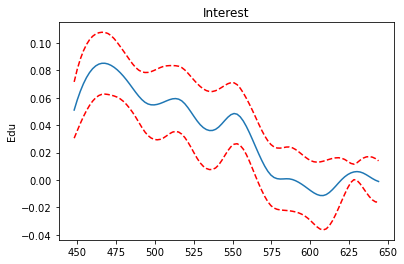

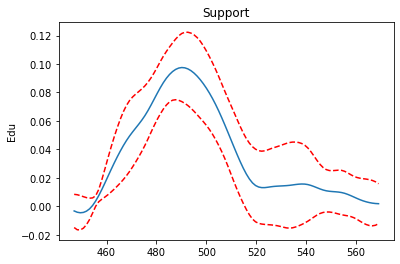

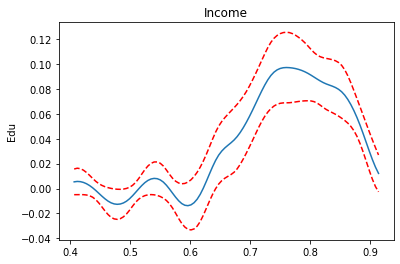

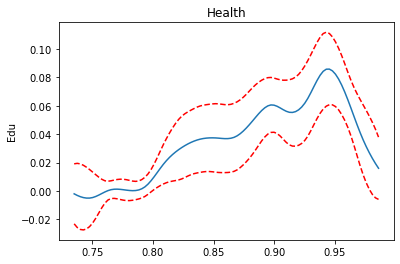

In [15]:
part_plot(second_model, X)

### Как это реально выглядит?

D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


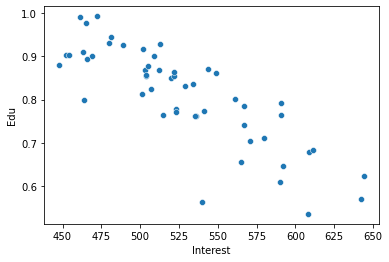

D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


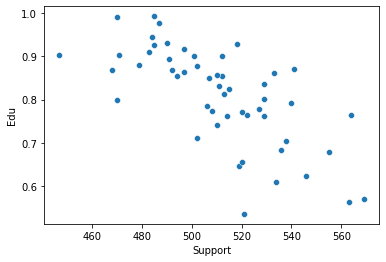

D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


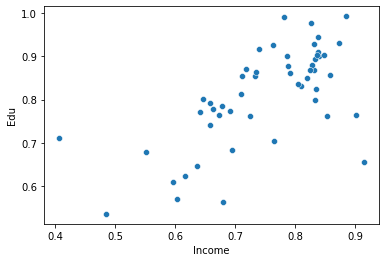

D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


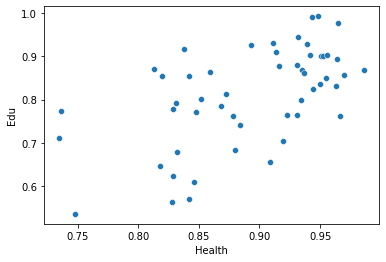

In [16]:
for name in X.columns:
    
    sns.scatterplot(X[name], y)
    plt.show()

### Время оптимизации:

In [17]:
#будем итерировать по сплайнам

spline = np.arange(4, 15, 1) #от 4 до 14
splines = [spline] * 4 #чтобы было на каждый параметр 

In [20]:
splines

[array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])]

In [21]:
model_opt_s = GAM(s(0) + s(1) + s(2) + s(3)).gridsearch(X.values, y,\
                                                        n_splines = splines)

100% (14641 of 14641) |##################| Elapsed Time: 0:06:27 Time:  0:06:27


In [22]:
model_opt_s.summary()

GAM                                                                                                       
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      6.3979
Link Function:                     IdentityLink Log Likelihood:                                  -5827.407
Number of Samples:                           52 AIC:                                            11669.6098
                                                AICc:                                           11672.4595
                                                GCV:                                                0.0048
                                                Scale:                                              0.0038
                                                Pseudo R-Squared:                                   0.7351
Feature Function                  Lam

<ipython-input-22-85c6176b8c58>:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  model_opt_s.summary()


Посмотрим на результат:

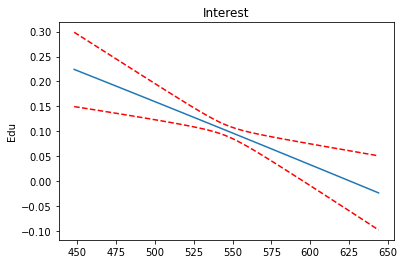

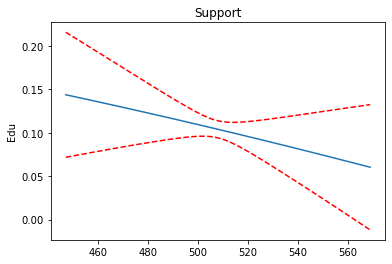

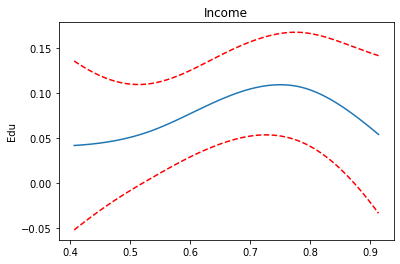

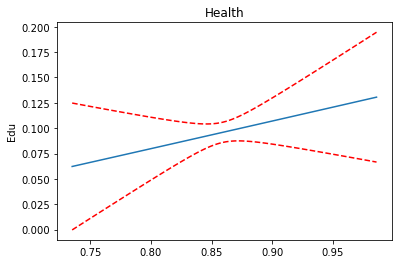

In [23]:
part_plot(model_opt_s, X)

In [16]:
#теперь попробуем сделать регуляризацию

lam = np.logspace(-3, 3, 11)
lams = [lam] * 4 

In [17]:
lams

[array([1.00000000e-03, 3.98107171e-03, 1.58489319e-02, 6.30957344e-02,
        2.51188643e-01, 1.00000000e+00, 3.98107171e+00, 1.58489319e+01,
        6.30957344e+01, 2.51188643e+02, 1.00000000e+03]),
 array([1.00000000e-03, 3.98107171e-03, 1.58489319e-02, 6.30957344e-02,
        2.51188643e-01, 1.00000000e+00, 3.98107171e+00, 1.58489319e+01,
        6.30957344e+01, 2.51188643e+02, 1.00000000e+03]),
 array([1.00000000e-03, 3.98107171e-03, 1.58489319e-02, 6.30957344e-02,
        2.51188643e-01, 1.00000000e+00, 3.98107171e+00, 1.58489319e+01,
        6.30957344e+01, 2.51188643e+02, 1.00000000e+03]),
 array([1.00000000e-03, 3.98107171e-03, 1.58489319e-02, 6.30957344e-02,
        2.51188643e-01, 1.00000000e+00, 3.98107171e+00, 1.58489319e+01,
        6.30957344e+01, 2.51188643e+02, 1.00000000e+03])]

In [25]:
model_opt_reg = GAM(s(0, n_splines = 4) + s(1, n_splines = 4) \
                    + s(2, n_splines = 7) + s(3, n_splines = 4)).gridsearch(X.values, y,\
                                                                              lam = lams) 

100% (14641 of 14641) |##################| Elapsed Time: 0:04:35 Time:  0:04:35


In [26]:
model_opt_reg.summary()

GAM                                                                                                       
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      6.7724
Link Function:                     IdentityLink Log Likelihood:                                 -5915.2811
Number of Samples:                           52 AIC:                                            11846.1069
                                                AICc:                                           11849.2615
                                                GCV:                                                0.0048
                                                Scale:                                              0.0037
                                                Pseudo R-Squared:                                   0.7432
Feature Function                  Lam

<ipython-input-26-86a34a65ce0c>:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  model_opt_reg.summary()


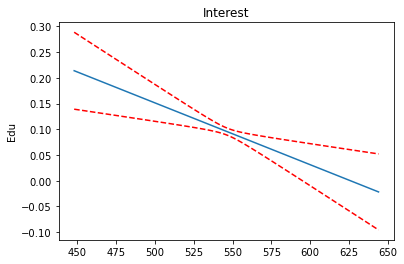

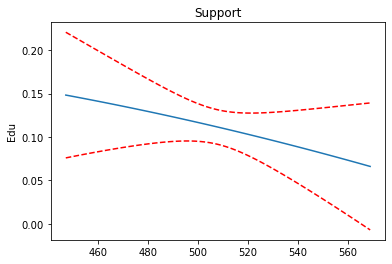

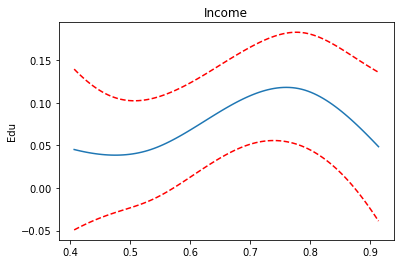

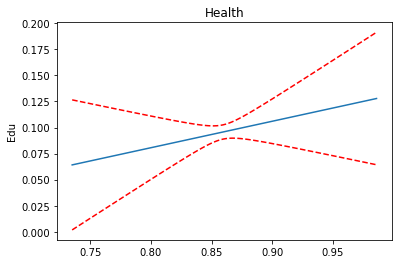

In [27]:
part_plot(model_opt_reg, X)

### Попробуем другое распределение

Для логистической регрессии попробуем данные побольше - теперь это [данные по рабочим из Средне-Атлантического региона США](https://rdrr.io/cran/ISLR/man/Wage.html):

In [18]:
# другие данные

wage = pd.read_csv('https://raw.githubusercontent.com/JWarmenhoven/ISLR-python/master/Notebooks/Data/Wage.csv')

In [19]:
wage.head()

,Unnamed: 0,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,155159,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,11443,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [22]:
wage.shape #их 3000 человек

(3000, 13)

Попробуем предсказывать класс работы. Взглянем на уникальные значения:

In [31]:
wage.jobclass.unique()

array(['1. Industrial', '2. Information'], dtype=object)

Их как раз два - *промышленного* и *умственного* труда.

Также возьмём категориальную переменную в качестве предиктора - расу. 

In [32]:
wage.race.unique()

array(['1. White', '3. Asian', '4. Other', '2. Black'], dtype=object)

Итого зависимой переменной у нас является класс работы, независимыми - возраст, год сбора информации, раса и размер дохода:

In [24]:
X = wage.loc[:, ['age', 'year', 'race', 'wage']]
X['race'] = [i[0] for i in wage.race] #конвертируем в числовую переменную
X['race'] = X.race.astype('int64') - 1 #вычитаем 1, так как счёт идёт с нуля

In [26]:
X.dtypes

age       int64
year      int64
race      int64
wage    float64
dtype: object

In [27]:
X = wage.loc[:, ['age', 'year', 'race', 'wage']]
X['race'] = [i[0] for i in wage.race] #конвертируем в числовую переменную
X['race'] = X.race.astype('int64') - 1 #вычитаем 1, так как счёт идёт с нуля

y = np.where(wage.jobclass == '1. Industrial', 0, 1) #также конвертируем в числовую переменную

In [28]:
model_log = LogisticGAM(s(0) + s(1) + f(2) + s(3)).fit(X.values, y) #строим логистическую модель

In [29]:
model_log.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     31.2145
Link Function:                        LogitLink Log Likelihood:                                 -1962.2221
Number of Samples:                         3000 AIC:                                             3986.8732
                                                AICc:                                            3987.5945
                                                UBRE:                                               3.3373
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0558
Feature Function                  Lam

<ipython-input-29-1f3e7491c232>:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  model_log.summary()


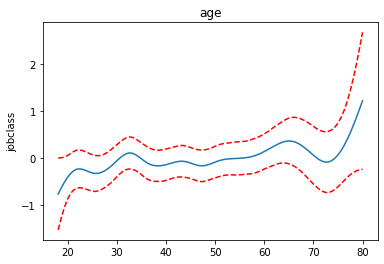

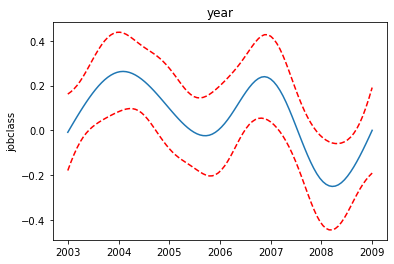

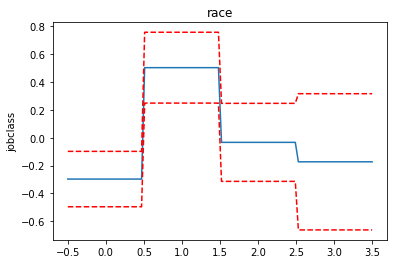

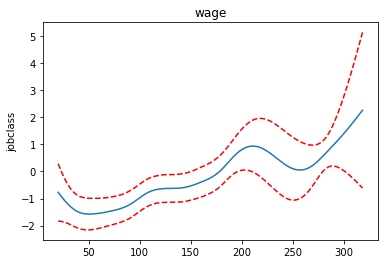

In [36]:
part_plot(model_log, X, 'jobclass')

In [29]:
model_log.accuracy(X, y) #точность предсказания

0.6126666666666667

Давайте снова отберём лучшую модель по количеству сплайнов:

In [42]:
model_log_opt = LogisticGAM(s(0) + s(1) + f(2) + s(3)).gridsearch(X.values, y,
                                                                 n_splines = splines)

100% (14641 of 14641) |##################| Elapsed Time: 0:17:28 Time:  0:17:28


In [43]:
model_log_opt.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     16.3238
Link Function:                        LogitLink Log Likelihood:                                  -1972.215
Number of Samples:                         3000 AIC:                                             3977.0774
                                                AICc:                                            3977.2903
                                                UBRE:                                                 3.33
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                    0.051
Feature Function                  Lam

<ipython-input-43-0b254a2cc664>:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  model_log_opt.summary()


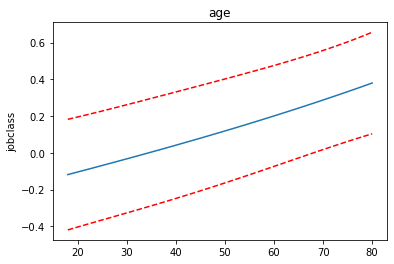

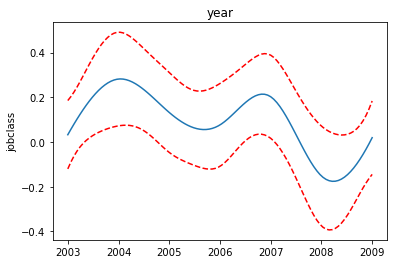

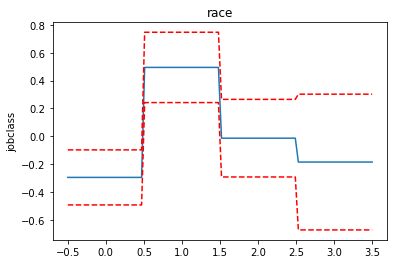

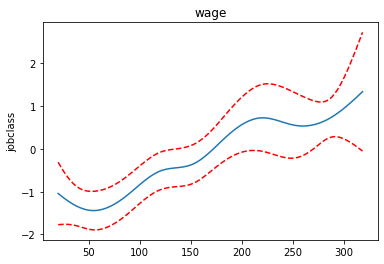

In [44]:
part_plot(model_log_opt, X, 'jobclass')

In [45]:
model_log_opt.accuracy(X, y)

0.603

### Ограничения на характер связи

В `pyGAM` могут быть четырёх типов - монотонная (убывающая либо возрастающая), выпуклая (*convex*) либо вогнутая (*concave*).

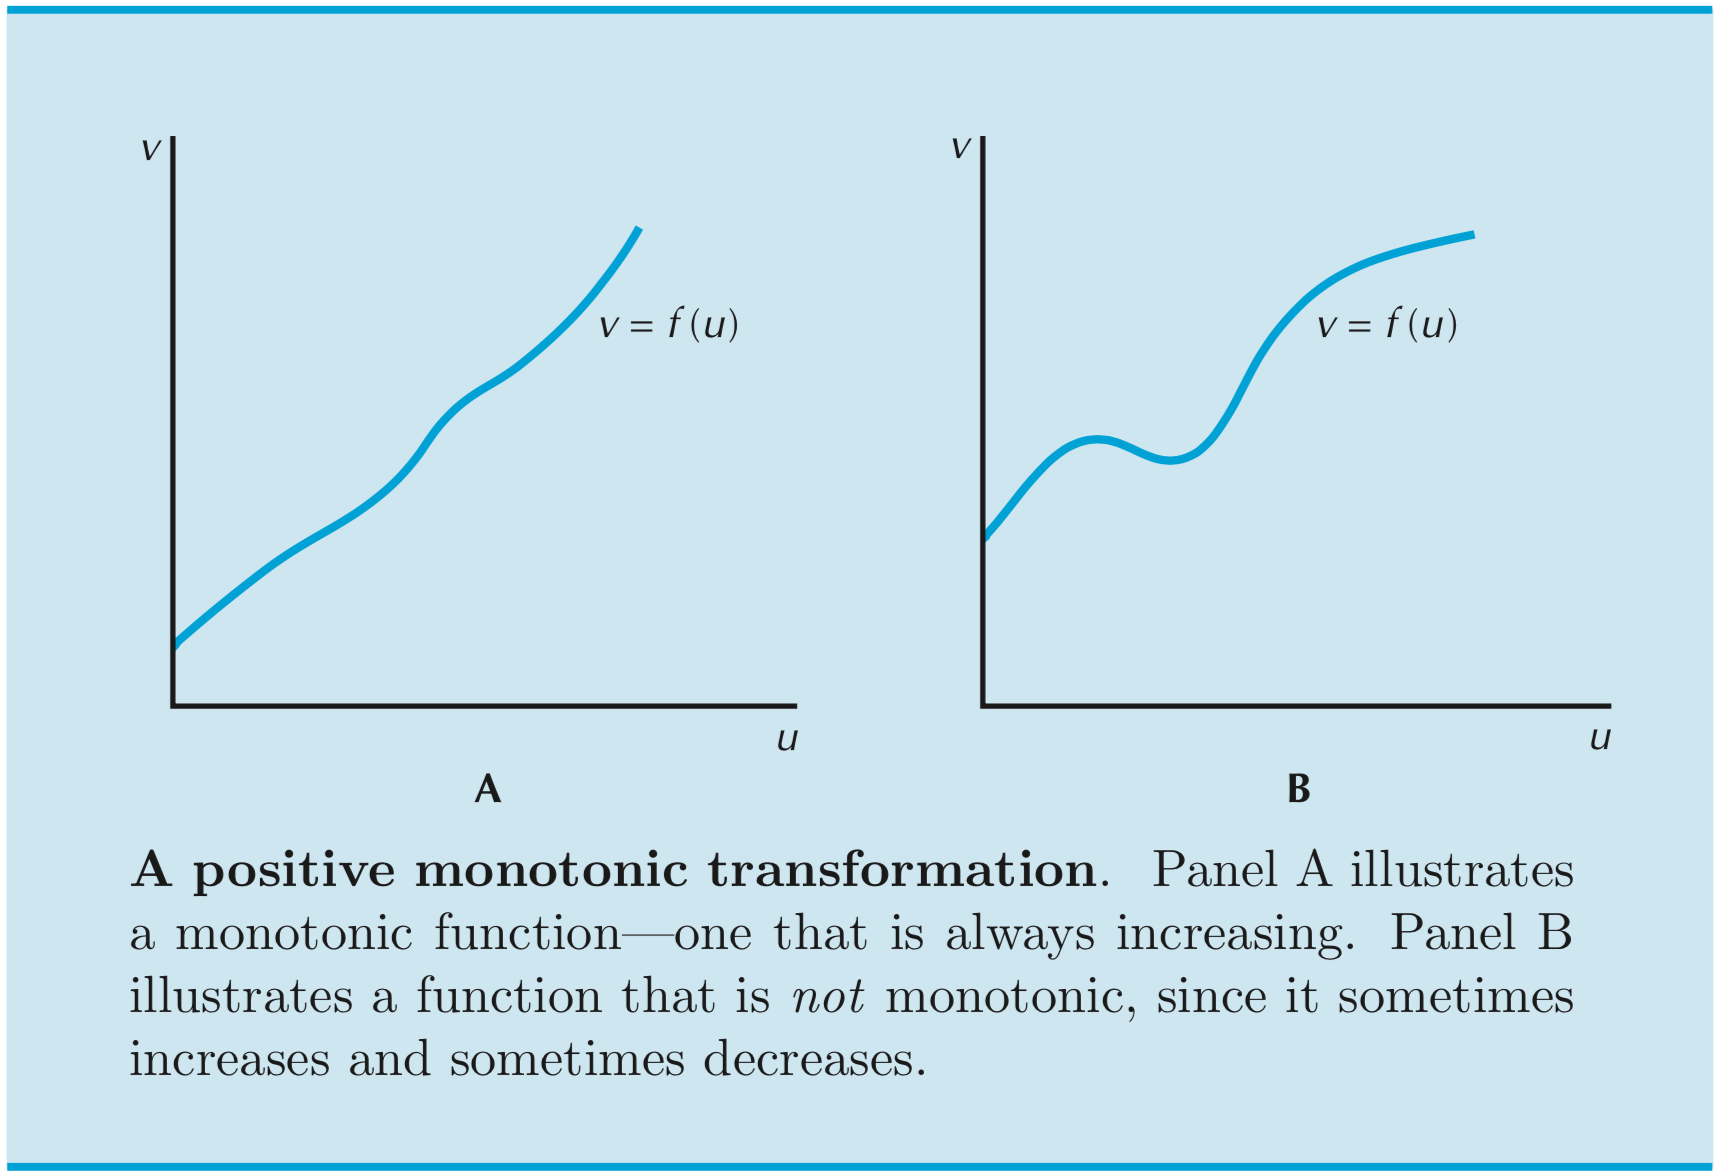

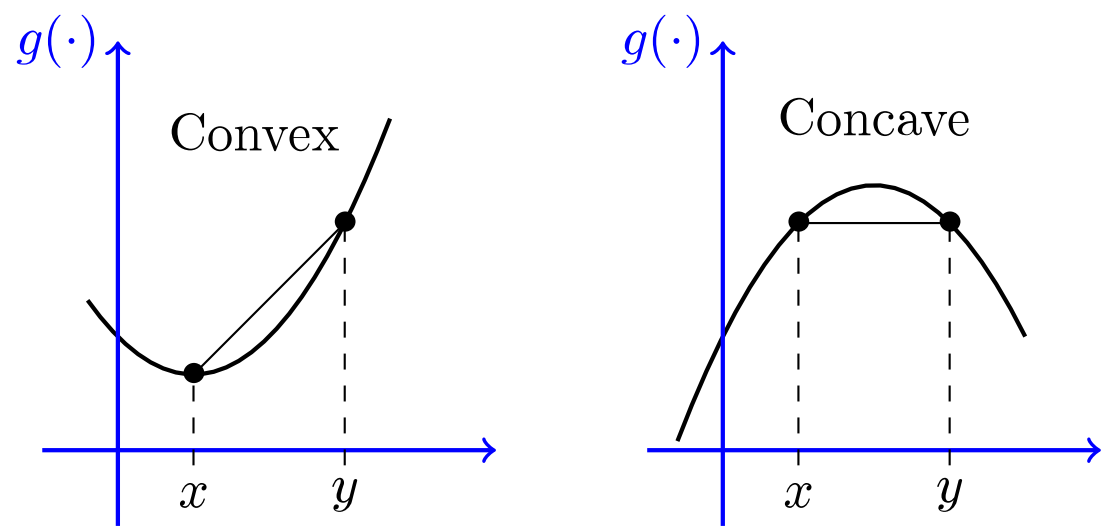

Попробуем построить модель, где связь возраста и зарплаты монотонно растёт, а год имеет форму вогнутой функции:

In [46]:
ok_model = LogisticGAM(s(0, n_splines = 4, constraints = 'monotonic_inc') 
                       + s(1, n_splines = 9, constraints = 'concave') 
                       + f(2) + s(3, n_splines = 12, constraints = 'monotonic_inc')).fit(X.values, y)

In [47]:
ok_model.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     11.0833
Link Function:                        LogitLink Log Likelihood:                                 -1978.4927
Number of Samples:                         3000 AIC:                                             3979.1521
                                                AICc:                                             3979.258
                                                UBRE:                                               3.3293
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                    0.048
Feature Function                  Lam

<ipython-input-47-b68de56efbe4>:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  ok_model.summary()


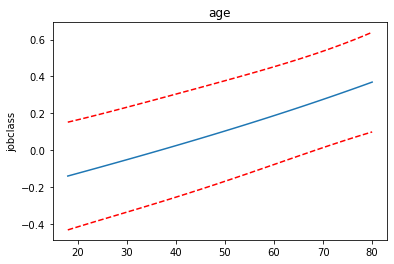

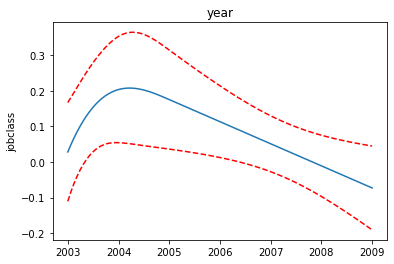

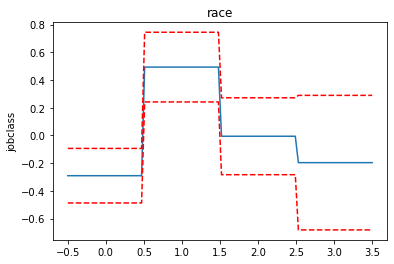

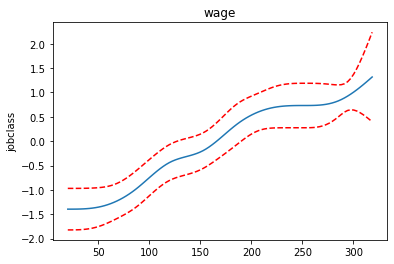

In [48]:
part_plot(ok_model, X, 'jobclass')

Нормальную модель каждый дурак сделать может. Гораздо интереснее сделать нарочно плохую модель. Укажем противоположные предыдущим ограничения:

In [49]:
oh_god_model = LogisticGAM(s(0, n_splines = 4, constraints = 'monotonic_dec') 
                       + s(1, n_splines = 9, constraints = 'convex') 
                       + f(2) + s(3, n_splines = 12, constraints = 'monotonic_dec')).fit(X.values, y)

In [50]:
oh_god_model.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      5.6433
Link Function:                        LogitLink Log Likelihood:                                 -2063.1407
Number of Samples:                         3000 AIC:                                             4137.5681
                                                AICc:                                            4137.6021
                                                UBRE:                                               3.3807
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0072
Feature Function                  Lam

<ipython-input-50-773437a57c11>:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  oh_god_model.summary()


**ОСТОРОЖНО** 

Ниже находится ИсКуСсТвО

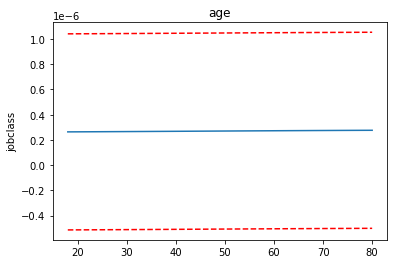

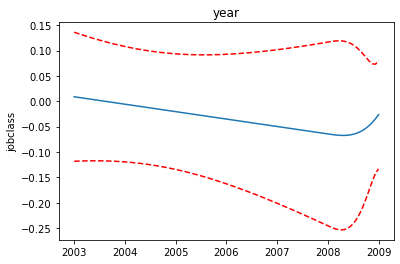

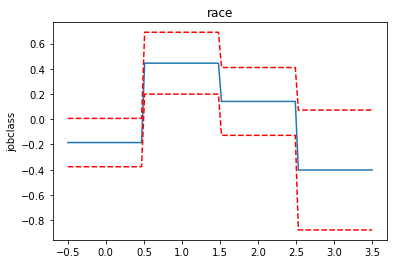

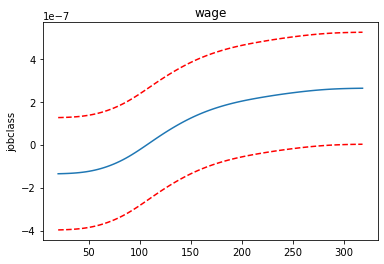

In [51]:
part_plot(oh_god_model, X, 'jobclass')

![](https://i.kym-cdn.com/entries/icons/facebook/000/010/566/060.jpg)